In [71]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Input Data

Source: https://openpowerlifting.gitlab.io/opl-csv/files/openipf-latest.zip

This page uses data from the OpenPowerlifting project, https://www.openpowerlifting.org.
You may download a copy of the data at https://gitlab.com/openpowerlifting/opl-data.

Openipf.org contains competition data from all International Powerlifting Federation (IPF) affiliates. The IPF is the governing body of powerlifting, recognized by the IOC and GAISF. The IPF has a strict anti-doping policy, adhering to the World Anti-Doping Agency (WADA) code. The IPF has an extensive competition calendar, featuring World Championships, European Championships, and other international events.

I am utilizing the International Powerlifting Federation (IPF) dataset in my study on peak age of strength because it represents the premier strength achievements of drug-tested human populations, providing a reliable and standardized measure of human strength capacity. Furthermore, the IPF's stringent judging standards, including rigorous referee certification criteria (e.g., requiring referees to have a minimum of 2 years of experience and pass a written exam), ensure that the data reflects the highest level of technical proficiency and accuracy.

In [72]:
# Reading OpenPowerlifting Data
raw = pd.read_csv('openipf-2025-03-01-e67afafd.csv', low_memory = False)

In [73]:
# Keep only Raw (No equipment, wraps, or single-ply, etc..)
raw_df = raw[raw['Equipment']=='Raw'].copy()

Data was pulled from OpenPowerlifting on March 6, 2025. Each row of the data is an athlete's performance from one event.

# Data Cleansing

Only data from 2019 onwards is considered, as the recent surge in popularity of powerlifting has led to more representative competitions that reflect current standards, training methods, and nutritional knowledge. This focus on recent data ensures accuracy not only for top-tier athletes but also for the broader population.

In [74]:
raw_df = raw_df[pd.to_datetime(raw_df['Date'])>='2019-01-01'].copy()

Keeping top lift: if a 4th attempt was successful use that weight if not, use the best of the 3 attempts.

In [75]:
raw_df['Squat'] = np.where((raw_df['Squat4Kg'].notnull())&(raw_df['Squat4Kg']>0), raw_df['Squat4Kg'], raw_df['Best3SquatKg'])
raw_df['Bench'] = np.where((raw_df['Bench4Kg'].notnull())&(raw_df['Bench4Kg']>0), raw_df['Bench4Kg'], raw_df['Best3BenchKg'])
raw_df['Dead'] = np.where((raw_df['Deadlift4Kg'].notnull())&(raw_df['Deadlift4Kg']>0), raw_df['Deadlift4Kg'], raw_df['Best3DeadliftKg'])
raw_df['Total'] = raw_df['Squat'] + raw_df['Bench'] + raw_df['Dead']

Dropping any rows where Sex, Age, or Bodyweight is missing

In [76]:
raw_df = raw_df[raw_df[['Age', 'BodyweightKg', 'Sex']].notna().all(axis=1)].reset_index(drop=True)\
[['Sex', 'Event', 'Age','BodyweightKg','Tested','Squat', 'Bench', 'Dead', 'Total']]

Creating weight groups
- In this study the weight groups will aggregate the IPF weight cutoffs to create four total weight groups.

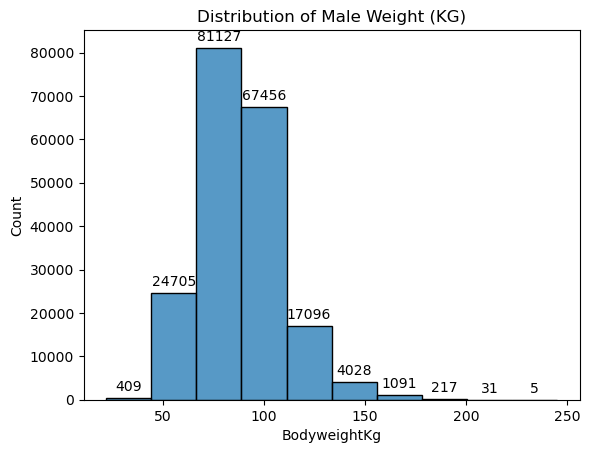

In [77]:
m_weight = sns.histplot(raw_df[raw_df['Sex']=='M']['BodyweightKg'], bins = 10)
plt.title('Distribution of Male Weight (KG)')
for rect in m_weight.patches:
    height = rect.get_height()
    width = rect.get_x() + rect.get_width() / 2
    count = int(height)
    plt.annotate(f'{count}', xy=(width, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

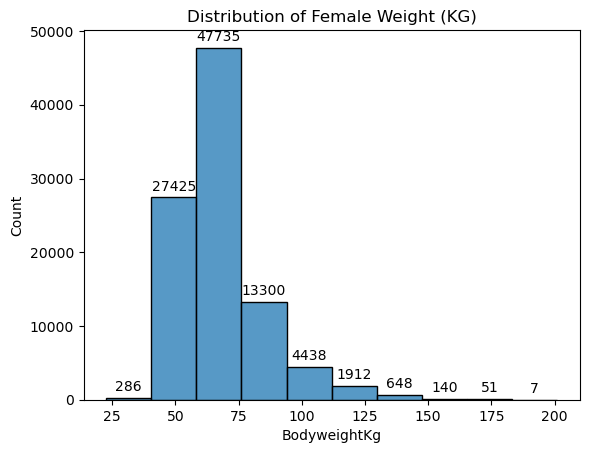

In [78]:
f_weight = sns.histplot(raw_df[raw_df['Sex']=='F']['BodyweightKg'], bins = 10)
plt.title('Distribution of Female Weight (KG)')
for rect in f_weight.patches:
    height = rect.get_height()
    width = rect.get_x() + rect.get_width() / 2
    count = int(height)
    plt.annotate(f'{count}', xy=(width, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

In [79]:
raw_df['Weight'] = np.where(raw_df['Sex'] == 'F',
         np.where((raw_df['BodyweightKg']>0)&(raw_df['BodyweightKg']<=52),'Light',
                  np.where((raw_df['BodyweightKg']>52)&(raw_df['BodyweightKg']<=63),'Middle',
                           np.where((raw_df['BodyweightKg']>63)&(raw_df['BodyweightKg']<=84),'Heavy',
                                    np.where(raw_df['BodyweightKg']>84,'SuperHeavy','ERROR')))),
         np.where(raw_df['Sex'] == 'M',
                  np.where((raw_df['BodyweightKg']>0)&(raw_df['BodyweightKg']<=66),'Light',
                  np.where((raw_df['BodyweightKg']>66)&(raw_df['BodyweightKg']<=83),'Middle',
                           np.where((raw_df['BodyweightKg']>83)&(raw_df['BodyweightKg']<=105),'Heavy',
                                    np.where(raw_df['BodyweightKg']>105,'SuperHeavy','ERROR')))),'NA'))

In [80]:
raw_df[raw_df['Weight'].isin(['ERROR','NA'])]

,Sex,Event,Age,BodyweightKg,Tested,Squat,Bench,Dead,Total,Weight
88841,Mx,BD,13.5,67.40,Yes,NaN,40.0,80.0,NaN,NA
98328,Mx,SBD,21.5,92.42,Yes,172.5,105.0,182.5,460.0,NA
99782,Mx,SBD,21.5,93.60,Yes,175.0,107.5,185.0,467.5,NA
100832,Mx,SBD,24.5,81.10,Yes,115.0,50.0,127.5,292.5,NA
112091,Mx,B,13.5,64.80,Yes,NaN,40.0,NaN,NaN,NA
118152,Mx,SBD,23.5,88.00,Yes,112.5,57.5,130.0,300.0,NA
124897,Mx,D,31.5,103.80,Yes,NaN,NaN,137.5,NaN,NA
128570,Mx,SBD,24.5,87.00,Yes,125.0,85.0,140.0,350.0,NA


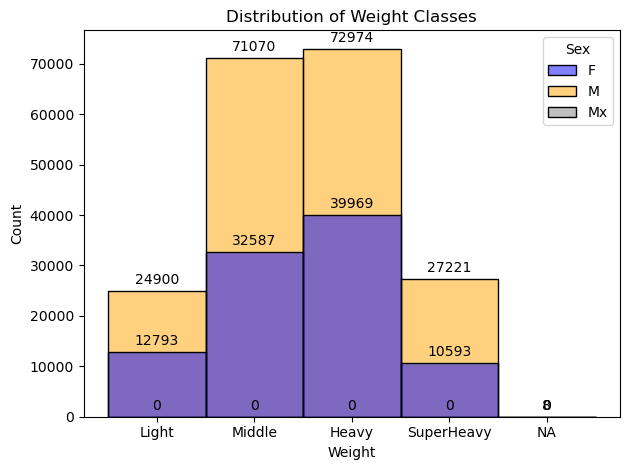

In [81]:
colors = {'F': 'blue', 'M': 'orange','Mx': 'grey'}
palette = [colors[sex] for sex in raw_df['Sex'].unique()]
raw_df['Weight'] = pd.Categorical(raw_df['Weight'], categories=['Light', 'Middle', 'Heavy', 'SuperHeavy', 'NA'], ordered=True)

histogram = sns.histplot(data=raw_df, x='Weight', hue='Sex', palette=palette)

for bar in histogram.patches:
    height = bar.get_height()
    width = bar.get_x() + bar.get_width() / 2
    count = int(height)
    plt.annotate(f'{count}', xy=(width, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Distribution of Weight Classes')
plt.tight_layout()

Removing Mx Sex

In [82]:
raw_df = raw_df[raw_df['Sex'] !='Mx'].copy()

Creating Age Bins
8 Age Brackets using the IPF age categories with life stage cycles.
- (0-15): Teen
- (15-20): Junior
- (20-25): EarlyOpen
- (25-30): Open
- (30-35): LateOpen
- (35-45): EarlyMaster
- (45-55): Master
- (55+): Elder

In [83]:
age_bins = [0, 15, 20, 25, 30, 35, 45, 55, float('inf')]
age_labels = ['Teen', 'Junior', 'EarlyOpen', 'Open', 'LateOpen', 'EarlyMaster','Master','Elder']

raw_df['AgeGroup'] = pd.cut(raw_df['Age'], bins=age_bins, labels=age_labels, right=False)

/var/folders/51/skxyry2n243dl2zyht_7lp700000gn/T/ipykernel_3144/1344816135.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  hist = sns.histplot(data = raw_df, x = 'AgeGroup', hue = 'Sex',  palette=palette)


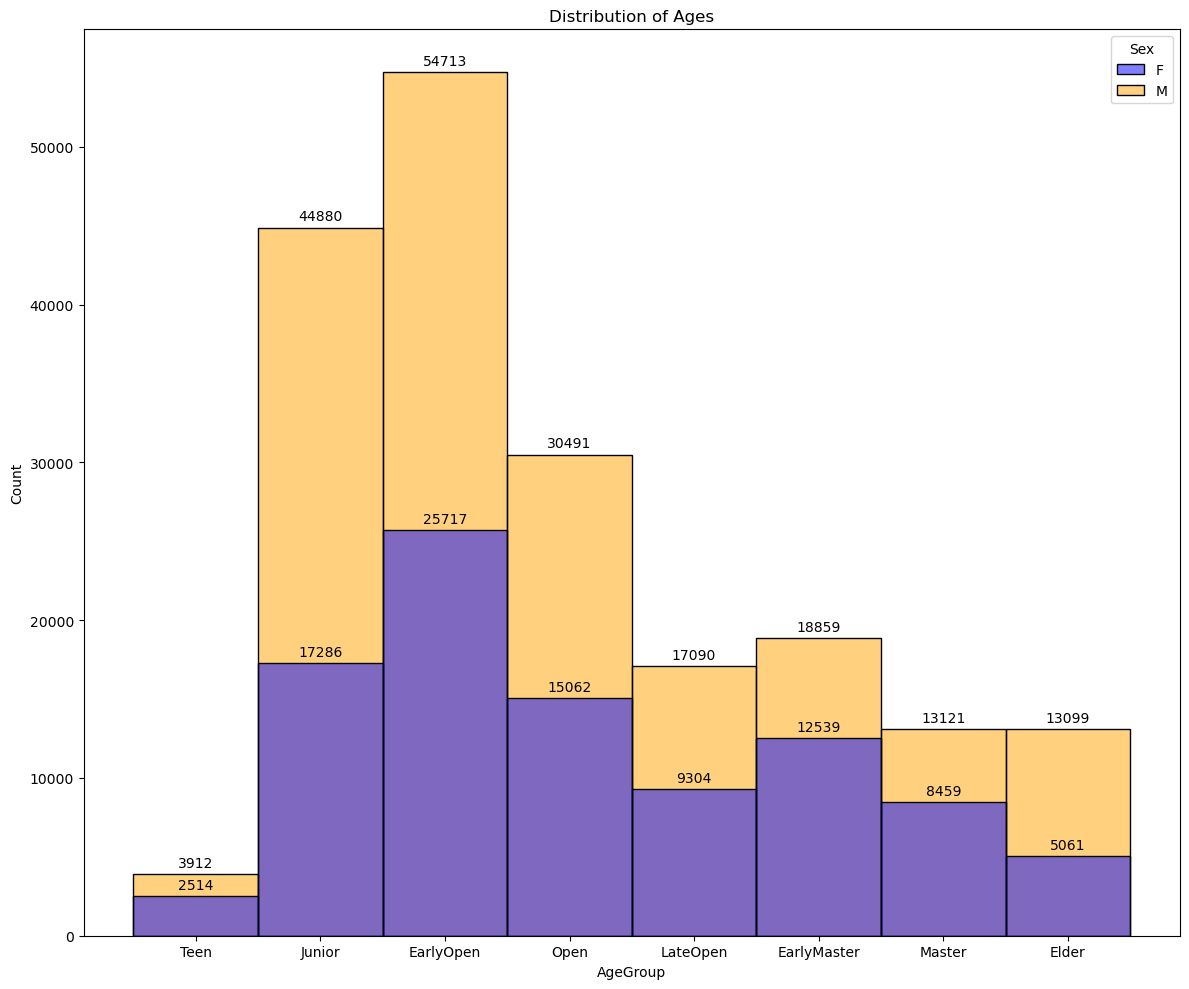

In [84]:
plt.figure(figsize = (12,10))
hist = sns.histplot(data = raw_df, x = 'AgeGroup', hue = 'Sex',  palette=palette)
for bar in hist.patches:
    height = bar.get_height()
    width = bar.get_x() + bar.get_width() / 2
    count = int(height)
    plt.annotate(f'{count}', xy=(width, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    
plt.title('Distribution of Ages')
plt.tight_layout()

Removing competitions where a lifter did not complete all three lifts

In [85]:
raw_df = raw_df[raw_df['Total'].notnull()].copy()

Removing columns

In [86]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225658 entries, 0 to 292114
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Sex           225658 non-null  object  
 1   Event         225658 non-null  object  
 2   Age           225658 non-null  float64 
 3   BodyweightKg  225658 non-null  float64 
 4   Tested        225514 non-null  object  
 5   Squat         225658 non-null  float64 
 6   Bench         225658 non-null  float64 
 7   Dead          225658 non-null  float64 
 8   Total         225658 non-null  float64 
 9   Weight        225658 non-null  category
 10  AgeGroup      225658 non-null  category
dtypes: category(2), float64(6), object(3)
memory usage: 17.6+ MB


In [87]:
raw_df = raw_df.drop(['Tested','Event'], axis=1)

# Export

In [88]:
raw_df.to_pickle('data.pkl')